## 초기셋팅

In [ ]:
import os
import torch
import torch.nn.functional as F
import yaml
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import torch.backends.cudnn as cudnn
import time
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

### CutPaste 

In [ ]:
#그림자x
def imaginary_img(x_train, y_train, cache_dir):
    empty_image_list = []
    empty_label_list = []
    imag_images = []
    imag_labels = []
    red1 = np.array([0, 50,50])
    red2 = np.array([15, 255,255])
    offset = 0
    count = 0

    for i in y_train : 
        lab = cv2.imread(i)
        if np.max(lab)==0 :
            empty_label_list.append(i)
            empty_image_list.append(i.replace('label','rgb'))
   
    y_train = list(set(y_train) - set(empty_label_list))
    y_train = [y for y in y_train if y[y.find('label')+6:y.find('_',-7)] in selectImage]
    print(len(y_train))
    print(len(empty_image_list))

    for j in range(len(empty_image_list)):
        img_bg = cv2.imread(empty_image_list[j])
        lab_bg = cv2.imread(empty_label_list[j])

        fg_list = random.sample(y_train, 4)

        for k in fg_list :
            img_fg = cv2.imread(k.replace('label', 'rgb'))
            lab_fg = cv2.imread(k)
            hsv = cv2.cvtColor(lab_fg, cv2.COLOR_BGR2HSV)

            mask = cv2.inRange(hsv, red1, red2)
            if np.max(mask)==0:
                continue
            

            mask_inv = cv2.bitwise_not(mask)

            try :
                fg_image = cv2.bitwise_and(img_fg, img_fg, mask=mask)
                fg_label = cv2.bitwise_and(lab_fg, lab_fg, mask=mask)
            except : 
                continue

##
            imag_label = lab_bg+fg_label

            try :
                bg = cv2.bitwise_and(img_bg, img_bg, mask=mask)
            except : 
                continue

            mask_cloud = np.full_like(bg, 255)
            height, width = bg.shape[:2]
            center = (width//2, height//2)
            cloud = cv2.seamlessClone(fg_image, bg, mask_cloud, center, cv2.NORMAL_CLONE)
            imag_img = cv2.bitwise_and(img_bg, img_bg, mask=mask_inv)
            imag_img = imag_img+cloud
##

            filename = 'IMAGINE_'+str(count)+'.png'
            imag_images.append(os.path.join(cache_dir, "rgb_"+filename))
            imag_labels.append(os.path.join(cache_dir, "label_"+filename))
            cv2.imwrite(os.path.join(cache_dir, 'rgb_'+filename), imag_img)
            cv2.imwrite(os.path.join(cache_dir, 'label_'+filename), imag_label)
            count=count+1

    return imag_images, imag_labels   


In [ ]:
#그림자 o
def imaginary_img(x_train, y_train, cache_dir):
    os.makedirs(cache_dir, exist_ok=True)
    empty_image_list = []
    empty_label_list = []
    imag_images = []
    imag_labels = []
    red1 = np.array([0, 50,50])
    red2 = np.array([15, 255,255])
    offset = 0
    count = 0

    for i in y_train : 
        lab = cv2.imread(i)
        if np.max(lab)==0 :
            empty_label_list.append(i)
            empty_image_list.append(i.replace('label','rgb'))
    x_train = list(set(x_train) - set(empty_image_list))
    y_train = list(set(y_train) - set(empty_label_list))
    print(len(empty_image_list))

    for j in range(len(empty_image_list)):
        img_bg = cv2.imread(empty_image_list[j])
        lab_bg = cv2.imread(empty_label_list[j])

        for k in y_train :
            img_fg = cv2.imread(k.replace('label', 'rgb'))
            lab_fg = cv2.imread(k)
            hsv = cv2.cvtColor(lab_fg, cv2.COLOR_BGR2HSV)

            mask = cv2.inRange(hsv, red1, red2)
            if np.max(mask)==0:
                continue
            

            mask_inv = cv2.bitwise_not(mask)

            try :
                fg_image = cv2.bitwise_and(img_fg, img_fg, mask=mask)
                fg_label = cv2.bitwise_and(lab_fg, lab_fg, mask=mask)
            except : 
                continue


##          
            shadow_rate = random.randrange(2,5)
            x = random.randrange(10,50)
            y = random.randrange(10,50)

            shadow_label = np.zeros((400,400,3),np.uint8)
            cv2.rectangle(shadow_label, (0,0),(400,400),(0,255,255),-1)
            
            shadow = np.insert(mask, 0, 0, axis=1)
            for i in range(0,x-1):
                shadow = np.insert(shadow, 0, 0, axis=1)
            shadow = np.delete(shadow, range(400,400+x), axis=1)
            for i in range(0,y):
                shadow = np.insert(shadow, 0, 0, axis=0)
            shadow = np.delete(shadow, range(400,400+y), axis=0)
            shadow_inv = cv2.bitwise_not(shadow)

            
            try : 
                shadow_label = cv2.bitwise_and(shadow_label, shadow_label, mask=shadow)
                shadow = (cv2.bitwise_and(img_bg, img_bg, mask=shadow))/shadow_rate
            except :
                continue


            imag_img = cv2.bitwise_and(img_bg, img_bg, mask=shadow_inv)
            imag_img = imag_img+shadow
            
            imag_label = lab_bg + shadow_label
            imag_label = cv2.bitwise_and(imag_label, imag_label, mask=mask_inv)
            imag_label = imag_label+fg_label

            try :
                bg = cv2.bitwise_and(img_bg, img_bg, mask=mask)
            except : 
                continue

            mask_cloud = np.full_like(bg, 255)
            height, width = bg.shape[:2]
            center = (width//2, height//2)
            cloud = cv2.seamlessClone(fg_image, bg, mask_cloud, center, cv2.NORMAL_CLONE)
            imag_img = cv2.bitwise_and(imag_img, imag_img, mask=mask_inv)
            imag_img = imag_img+cloud
##

            filename = k[-11:-4]+'_'+str(j)+'.png'
            imag_images.append(os.path.join(cache_dir, "rgb_"+filename))
            imag_labels.append(os.path.join(cache_dir, "label_"+filename))
            cv2.imwrite(os.path.join(cache_dir, 'rgb_'+filename), imag_img)
            cv2.imwrite(os.path.join(cache_dir, 'label_'+filename), imag_label)

            #print(filename)

    return imag_images, imag_labels   


## 코드 구성 테스트(정리x)

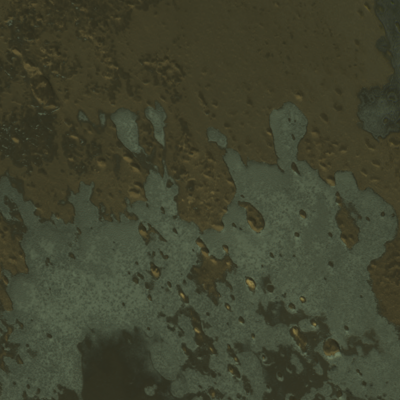

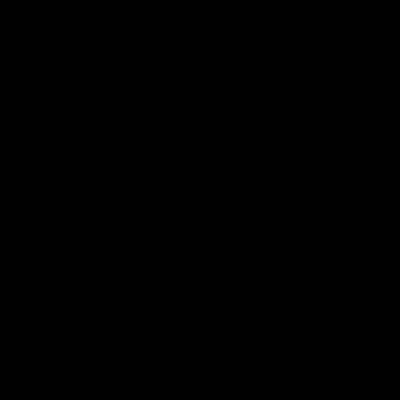

In [ ]:
#클래스가 없는 이미지 출력
img_path = ''
lab_path = ''
img_bg = cv2.imread(img_path)
lab_bg = cv2.imread(lab_path)
cv2_imshow(img_bg)
cv2_imshow(lab_bg)

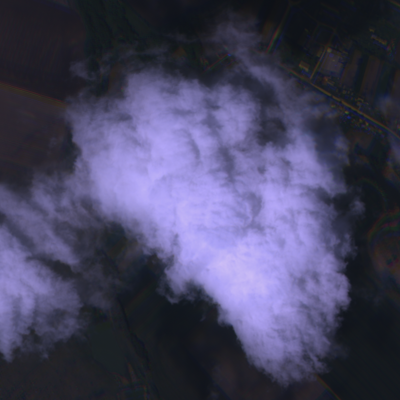

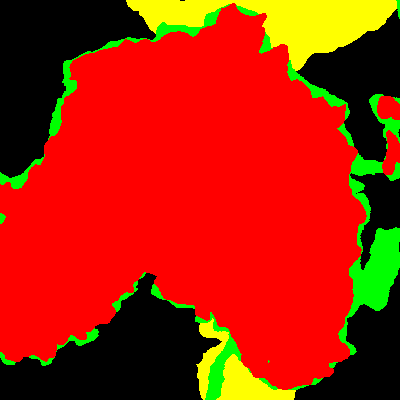

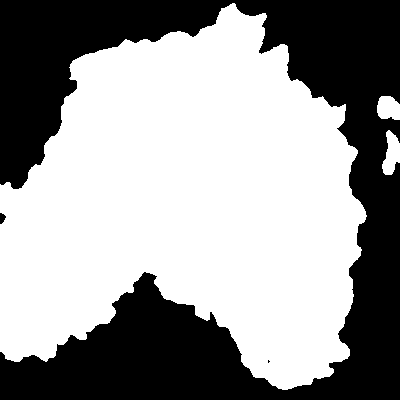

In [ ]:
#구름이 있는 이미지에서 두꺼운 구름만 검출(옅은 구름은 배경 데이터도 일부 포함하기에 제외)
img_path = ''
lab_path = ''

img_fg = cv2.imread(img_path)
lab_fg = cv2.imread(lab_path)

hsv = cv2.cvtColor(lab_fg, cv2.COLOR_BGR2HSV)

red1 = np.array([0, 50,50])
red2 = np.array([15, 255,255])
mask = cv2.inRange(hsv, red1, red2)
mask_inv = cv2.bitwise_not(mask)
cv2_imshow(img_fg)
cv2_imshow(lab_fg)
cv2_imshow(mask)

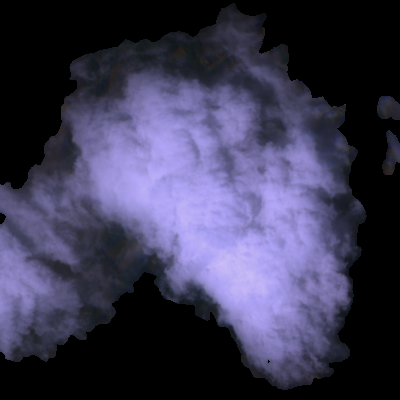

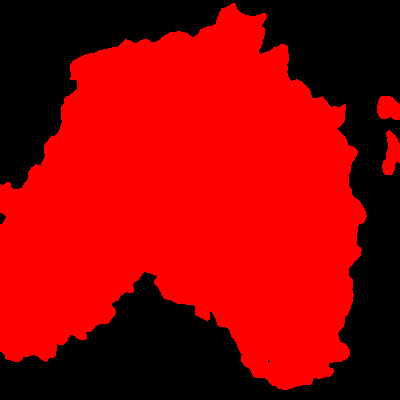

In [ ]:
fg = cv2.bitwise_and(img_fg, img_fg, mask=mask)
fg_label = cv2.bitwise_and(lab_fg, lab_fg, mask=mask)
cv2_imshow(fg)
cv2_imshow(fg_label)

(400, 400, 3)
(400, 400, 3)


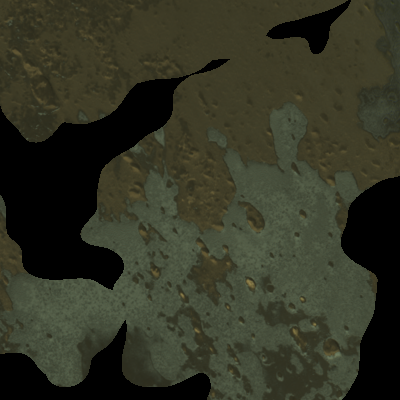

(400, 400, 3)


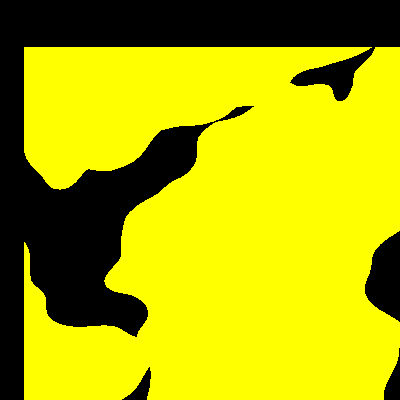

In [ ]:
#가상 그림자 생성 연구
shadow_rate = random.randrange(2,5)
x = random.randrange(10,50)
y = random.randrange(10,50)

shadow_label = np.zeros((400,400,3),np.uint8)
cv2.rectangle(shadow_label, (0,0),(400,400),(0,255,255),-1)
            
shadow = np.insert(mask, 0, 0, axis=1)
for i in range(0,x-1):
    shadow = np.insert(shadow, 0, 0, axis=1)
shadow = np.delete(shadow, range(400,400+x), axis=1)
for i in range(0,y):
     shadow = np.insert(shadow, 0, 0, axis=0)
shadow = np.delete(shadow, range(400,400+y), axis=0)
shadow_inv = cv2.bitwise_not(shadow)

shadow_label = cv2.bitwise_and(shadow_label, shadow_label, mask=shadow)
#shadow = (cv2.bitwise_and(img_bg, img_bg, mask=shadow))/shadow_rate
shadow = (cv2.bitwise_and(img_bg, img_bg, mask=mask))
print(shadow.shape)
print(shadow_label.shape)

cv2_imshow(shadow)
print(shadow_label.shape)
cv2_imshow(shadow_label)


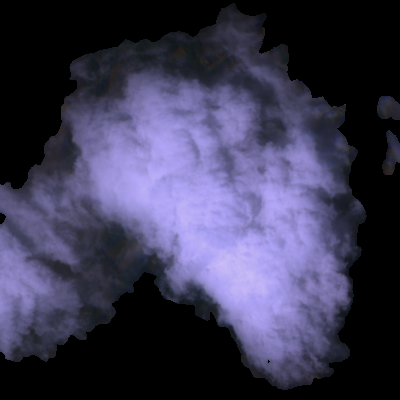

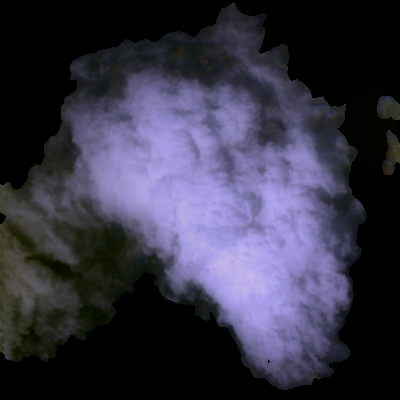

In [ ]:
#배경 데이터에 적합하게 일부 합성
bg = cv2.bitwise_and(img_bg, img_bg, mask=mask)

mask_cloud = np.full_like(bg, 255)

height, width = bg.shape[:2]
center = (width//2, height//2)
test = cv2.seamlessClone(fg, bg, mask_cloud, center, cv2.NORMAL_CLONE)
cv2_imshow(fg)
cv2_imshow(test)

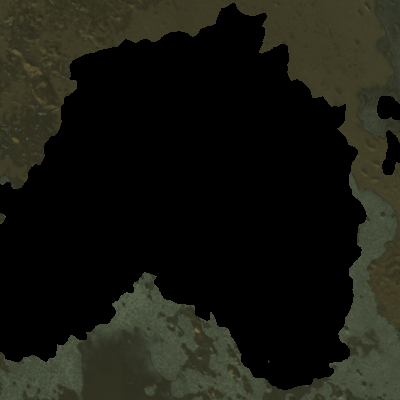

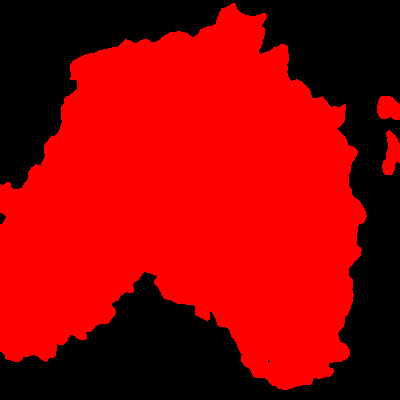

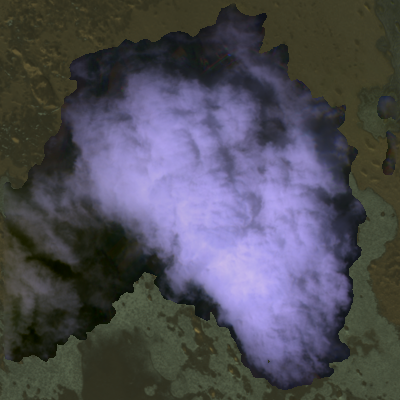

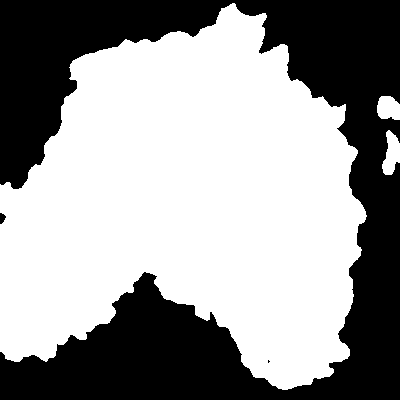

In [ ]:
offset = 0# -18

img_label = lab_bg # + shadow_label
img_label = cv2.bitwise_and(img_label, img_label, mask=mask_inv)
img_label = img_label+fg_label

bg = cv2.bitwise_and(img_bg, img_bg, mask=mask)
mask_cloud = np.full_like(bg, 255)
height, width = bg.shape[:2]
center = (width//2, height//2)
cloud = cv2.seamlessClone(fg, bg, mask_cloud, center, cv2.NORMAL_CLONE)

img_bg = cv2.bitwise_and(img_bg, img_bg, mask=mask_inv)
cv2_imshow(img_bg)
img_bg = img_bg+cloud

cv2_imshow(img_label)
cv2_imshow(img_bg)
cv2_imshow(mask)

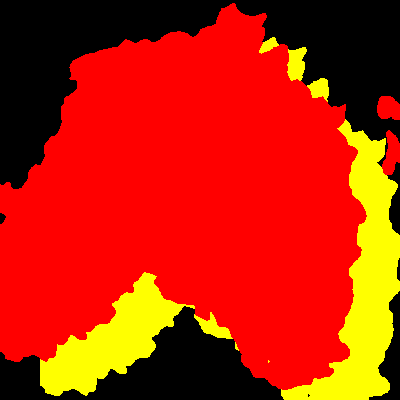

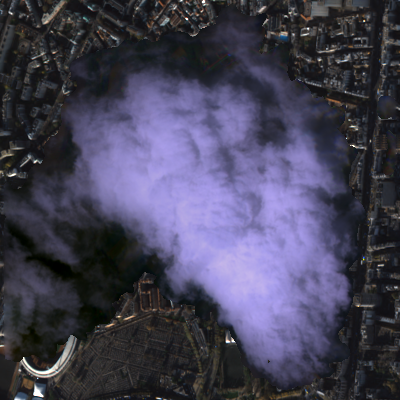

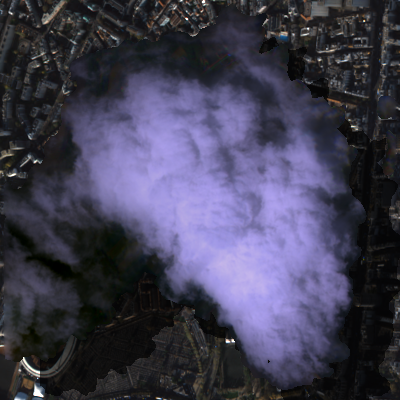

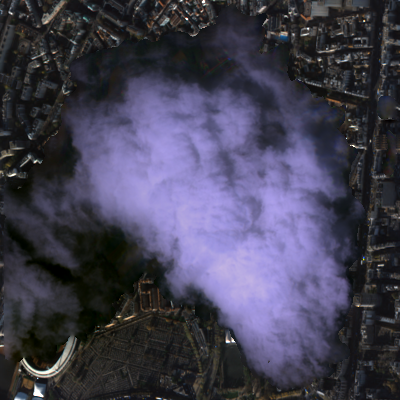

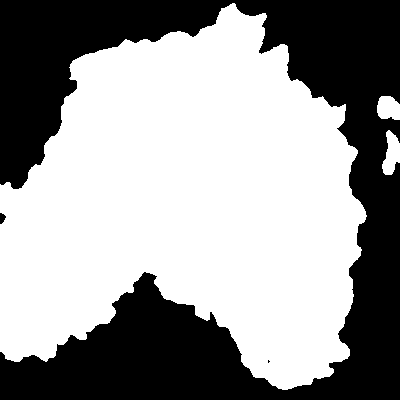

In [ ]:
offset = 0# -18

img_bg2 = cv2.bitwise_and(img_bg, img_bg, mask=shadow_inv)
img_bg2 = img_bg2+shadow
#img_bg2 = img_bg

img_label = lab_bg + shadow_label
img_label = cv2.bitwise_and(img_label, img_label, mask=mask_inv)
img_label = img_label+fg_label
cv2_imshow(img_label)

height, width = img_fg.shape[:2]
center = (width//2+offset, height//2+offset)
normal = cv2.seamlessClone(fg, img_bg, mask, center, cv2.NORMAL_CLONE)

cloud = cv2.bitwise_and(normal, normal, mask=mask)
img_bg2 = cv2.bitwise_and(img_bg2, img_bg2, mask=mask_inv)
img_bg2 = img_bg2+test

cv2_imshow(img_bg)
cv2_imshow(img_bg2)
cv2_imshow(normal)
cv2_imshow(mask)